# Introduction

This notebook assumes you have activated credentials with the CAVE client. CAVE (Connectome Annotation Versioning Engine) is built and supported by a collaboration between the Seung lab at Princeton and the Allen Institute for Brain Science. It allows for programmatic access to the tables associated with Minnie and other datasets. [Github](https://github.com/seung-lab/CAVEclient) 

CAVE setup instructions are [here](https://github.com/AllenInstitute/MicronsBinder/blob/master/notebooks/mm3_intro/CAVEsetup.ipynb).

CAVE tutorial for querying the data is [here](https://github.com/AllenInstitute/MicronsBinder/blob/master/notebooks/mm3_intro/SynapseAndAnnotationQuery.ipynb).

## Using CAVEclient to query data

In [1]:
from caveclient import CAVEclient

In [2]:
# this is the datastack name of the public release
# passing it will auto-configure many of the services
client = CAVEclient('minnie65_public_v117')

### View available annotation tables

In [3]:
client.materialize.get_tables()

['nucleus_detection_v0',
 'synapses_pni_2',
 'nucleus_neuron_svm',
 'proofreading_status_public_release',
 'func_unit_em_match_release']

### Query functionally matched EM neurons

In [4]:
import pandas as pd

In [5]:
matched_df = client.materialize.query_table('func_unit_em_match_release')
matched_df

### Column descriptions:

<b>id:</b> a unique identifier for this row

<b>valid:</b> internal check, uniformly ‘t’

<b>pt_position_{x,y,z}:</b> the location in 4,4,40 nm voxels at a cell body for the cell

<b>pt_supervoxel_id:</b> the ID of the supervoxel from the watershed segmentation that is under the pt_position

<b>pt_root_id:</b> the ID of the segment/root_id under the pt_position from the Proofread Segmentation (v117).

<b>session:</b> the ID indicating the imaging period for the mouse

<b>scan_idx:</b> the index of the scan within the imaging session

<b>unit_id:</b> the ID of the functional ROI (unique per scan)

### Select a random entry

In [6]:
entry = matched_df.sample(1)
entry

,id,valid,pt_supervoxel_id,pt_root_id,session,scan_idx,unit_id,pt_position
177,178,t,88328099594464245,864691136194108374,6,7,6861,"[171504, 175280, 24197]"


In [7]:
segment = entry.pt_root_id.values[0] # get ID of segment to visualize
centroid = entry.pt_position.values[0] # get centroid of segment

## View entry in Neuroglancer

### Flat segmentation

The flat segmentation is a complete segmentation of the entire Minnie volume. It is fast-loading, with multi-scale 3D meshes. It is currently on v117 public.

Programmatic editing of Neuroglancer links can be accomplished using the Seung lab/ AIBS package [nglui](https://github.com/seung-lab/NeuroglancerAnnotationUI).

```python
pip install nglui
```

[Example notebook](https://github.com/seung-lab/NeuroglancerAnnotationUI/blob/master/examples/statebuilder_examples.ipynb)

In [8]:
from nglui import statebuilder # generate links in Seung lab a custom Neuroglancer deployment called Neuromancer

In [9]:
em_layer = statebuilder.ImageLayerConfig("precomputed://https://bossdb-open-data.s3.amazonaws.com/microns/minnie/minnie65-phase3-em/aligned/v1") # public em source
seg_layer = statebuilder.SegmentationLayerConfig("precomputed://gs://iarpa_microns/minnie/minnie65/seg", name='seg', fixed_ids=[segment]) # public segmentation source

view_options = {'layout': '3d',
                'zoom_3d': 3000,
                'position': centroid} # set zoom options and center on segment

sb = statebuilder.StateBuilder([em_layer, seg_layer], view_kws=view_options)

sb.render_state(url_prefix='https://ngl.microns-explorer.org/', return_as='html')

### Dynamic segmentation

The dynamic segmentation is a live-view of the current segmentation and mesh state that is altered by proofreading. **(It may take awhile to load)**

It is viewable in a modified version of Neuroglancer and accessible with [nglui](https://github.com/seung-lab/NeuroglancerAnnotationUI).

In [10]:
em_layer = statebuilder.ImageLayerConfig(client.info.image_source(), contrast_controls=True, black=0.35, white=0.7) # set EM layer 
seg_layer =  statebuilder.SegmentationLayerConfig(client.info.segmentation_source(),  name='seg', fixed_ids=[segment]) # set dynamic segmentation layer
view_options = {'layout': '3d',
                'zoom_3d': 3000,
                'position': centroid}  # set zoom options and center on segment

sb = statebuilder.StateBuilder([em_layer, seg_layer], view_kws=view_options) # generate statebuilder
sb.render_state(return_as='html') # render state as html link

# Access Functional data

This notebook assumes you have access to a copy of the SQL database that houses the functional data and the functional data schema repository. Instructions to download are [here](https://www.microns-explorer.org/cortical-mm3#f-data).

The contents of the SQL schema are accessed programmatically using [DataJoint](https://datajoint.io/). Find an example notebook for using DataJoint to access the functional data [here].

In [11]:
import datajoint as dj
from phase3 import nda, func, utils

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Convert entry to DataJoint compatible key

DataJoint tables can be restricted with dictionaries. Here we generate a dictionary of attributes that specify the unique functional ROI in the DataJoint schema. 

In [12]:
unit_key = entry[['session', 'scan_idx', 'unit_id']].to_dict(orient='records')[0]

### Fetch & plot activity trace, calcium trace, pupil radius, and treadmill

Here we use the key to fetch and plot a variety of data from the schema, including the unit's calcium & spike traces, and the scan's pupil trace and treadmill speed. 

Note: The `nda.ManualPupil` and `nda.Treadmill` tables only contain the `session` and `scan_idx` attributes, but can still be retrieved with the `unit_key`. The `unit_id` attribute is ignored when restricting against these tables.

In [13]:
nframes, fps = (nda.Scan & unit_key).fetch1('nframes', 'fps')  # fetch # frames and fps
time_axis = np.arange(nframes)/ fps # create time axis (seconds)
spike_trace = (nda.Activity & unit_key).fetch1('trace') # fetch spike trace
calcium_trace = (nda.ScanUnit * nda.Fluorescence & unit_key).fetch1('trace') # fetch calcium fluorescence trace
pupil_radius = (nda.ManualPupil & unit_key).fetch1('pupil_maj_r') # fetch manually segmented pupil trace 
treadmill = (nda.Treadmill & unit_key).fetch1('treadmill_velocity') # fetch treadmill speed

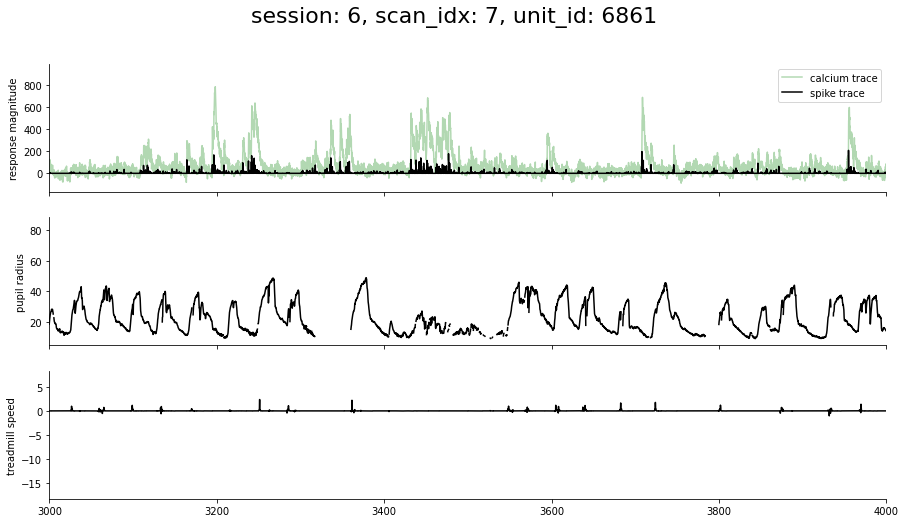

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 8), sharex=True)
ax1.plot(time_axis, calcium_trace, color='g', alpha=0.3, label='calcium trace')
ax1.plot(time_axis, spike_trace, color='k', label='spike trace')
ax2.plot(time_axis, pupil_radius, color='k')
ax3.plot(time_axis, treadmill, color='k')
ax3.set_xlim(3000, 4000) 
ax1.set_ylabel('response magnitude')
ax1.legend()
ax2.set_ylabel('pupil radius')
ax3.set_ylabel('treadmill speed')
fig.suptitle(f'session: {unit_key["session"]}, scan_idx: {unit_key["scan_idx"]}, unit_id: {unit_key["unit_id"]}', fontsize=22);
sns.despine()

### Compute & plot direction tuning curve

Here we use functions provided in the `func` module to retrieve the directional trials and responses for the functional unit from the Monet2 stimulus type and fit a Von Mises curve to the data. The individual trial response means and von mises curve are plotted below.

In [15]:
indices, directions, responses = func.concatenate_monet2(unit_key) # fetch Monet2 stimulus directions and responses for specified functional unit

In [16]:
x_pdf, pdf = func.von_mises_pdf(directions, responses) # compute von mises probability density function

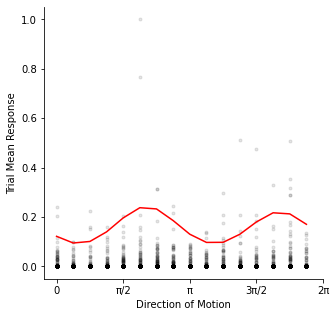

In [17]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(directions, responses/np.max(responses), '.k', alpha=0.1)
ax.plot(x_pdf, pdf, 'r')
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax.set_xticklabels(['0', '\u03C0/2', '\u03C0', '3\u03C0/2', '2\u03C0'])
ax.set_ylabel('Trial Mean Response')
ax.set_xlabel('Direction of Motion')
sns.despine()
plt.show()
plt.close()